# Sample MERRA-2 Along an Aircraft Trajectory
This is an example showing how to use GMAOpyobs utilities to sample MERRA-2 along a DC-8 aircraft trajectory described by a 60 second merge ICARTT format file.

This assumes that you have cloned GMAOpyobs Github repository, installed it in a directory called \\$AERODIR, and have added the following directory to your $PYTHONPATh environment variable:
\\$AERODIR/install/lib/Python

It also assumes you have the following grads style control file for the MERRA-2 files. An example of such a file is in this directory called inst3_3d_aer_Nv, and it points to files in a directory called MERRA2_all also in this directory.

The inst3_3d_aer_Nv MERRA-2 Collection contains 3-D aerosol mass mixing ratios on the native model vertical levels.

The GEOS aerosol optics files can be found at https://portal.nccs.nasa.gov/datashare/iesa/aerosol/ExtData/

In [1]:
# setting up my PYTHONPATH within discover JupyterHub, you don't need this when working from a terminal
# if you are using jupyterhub, use the conda env:sci2 kernel
import sys
sys.path.append('/gpfsm/dnb34/pcastell/workspace/GMAOpyobs_ipynb_examples/GMAOpyobs/install/lib/Python')

In [2]:
#DC-8 Example
from pyobs.sampler import TRAJECTORY
from pyobs.icartt import ICARTT

In [3]:
# set up some file names
# ictFile was created using the ASIA-AQ custom merging tool
# it is a 60s average, and contains PM data from AMS and SP2
ictFile = 'asiaaq-mrg60_dc8_20240217_RA_20240819T140653.ict'
m2data = '/home/pcastell/opendap/m2/inst3_3d_aer_Nv'
outFile = 'm2_ict_sampled.nc4'

In [4]:
# Read ICART file and get lon, lat, tyme
m = ICARTT(ictFile)
lon, lat, tyme = m.Nav['Longitude'], m.Nav['Latitude'], m.Nav['Time']

In [5]:
# create a trajectory oject
traj = TRAJECTORY(tyme,lon,lat,m2data)

In [6]:
# sample the MERRA-2 dataset along the trajectory, and return an xarray dataset
traj_ds = traj.sample()

In [7]:
# write data to a netcdf file
traj_ds.to_netcdf(outFile)

## Calculate PM Mass Along Aircraft Trejctory

In [7]:
from pyobs.aop import G2GAOP

In [10]:
# set up some filenames
# this configuration file can be found in src/config
config = '/home/slee72/nobackup/GMAOpyobs/src/config/m2_pm25.yaml'

In [12]:
# read the sampled aerosol profile data and optical tables
optics = G2GAOP(outFile,config=config)

In [13]:
# calculate PM2.5.  Use the aerodynamic diamter at 30% RH for your calculation
pm25 = optics.getPM(pmsize=2.5,aerodynamic=True,fixrh=0.30)

In [14]:
# get dry sulfate PM1 so we can compare to AMS obs
# this is a pretty rough cutoff, AMS recommends using a size transmission function
# needs to be implemented
pm1_su = optics.getPM(pmsize=1.0,aerodynamic=True,fixrh=0.0)

# AMS observes at STP (273 K & 1013 mb)
# so need to convert ambient concentration to STP 
# using the density of Air at STP = 1.2754 kg/m3
pm1_su['PM'] = pm1_su.PM*(1.2754/pm1_su.AIRDENS)

## Compare MERRA-2 to AMS Measurements on the DC-8

In [15]:
import matplotlib.pyplot as plt
from pyobs.sampler import addVertCoord

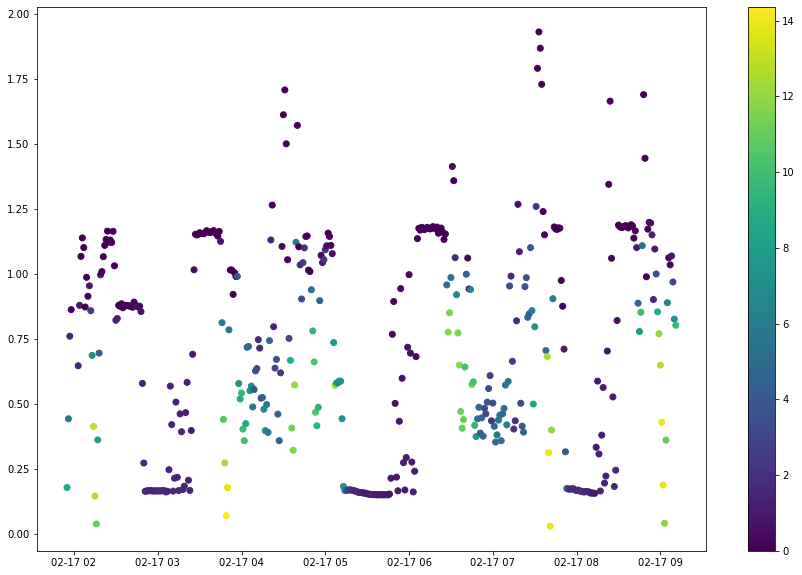

In [16]:
# AMS data
# MERRA-2 didn't include nitrates explicitly, so it is inluded in the sulfate
ams_pm1_su = m.Sulfate_PM1_AMS_60s_JIMENEZ + m.Ammonium_PM1_AMS_60s_JIMENEZ + m.Nitrate_PM1_AMS_60s_JIMENEZ
rad_alt = m.Radar_Altitude*0.0003048 # ft to km
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.scatter(tyme,rad_alt,c = ams_pm1_su)
plt.colorbar(im,ax=ax)

In [17]:
# MERRA-2
pm1_su.pipe(addVertCoord)
time = pm1_su.time.values
ntime = pm1_su.dims['time']
nlev = pm1_su.dims['lev']
time = np.repeat(time.reshape(ntime,1),nlev,axis=1)
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.contourf(time,pm1_su.Z,pm1_su.PM)
ax.set_ylim(0,2)
plt.colorbar(im,ax=ax)

NameError: name 'np' is not defined

In [16]:
# interpolate to the altitude of the aircraft
from scipy.interpolate import interp1d as interp
import numpy as np
pm1_su_int = np.array([interp(pm1_su.isel(time=itime).Z, pm1_su.isel(time=itime).PM,bounds_error=False)(rad_alt[itime]) for itime in range(ntime)])

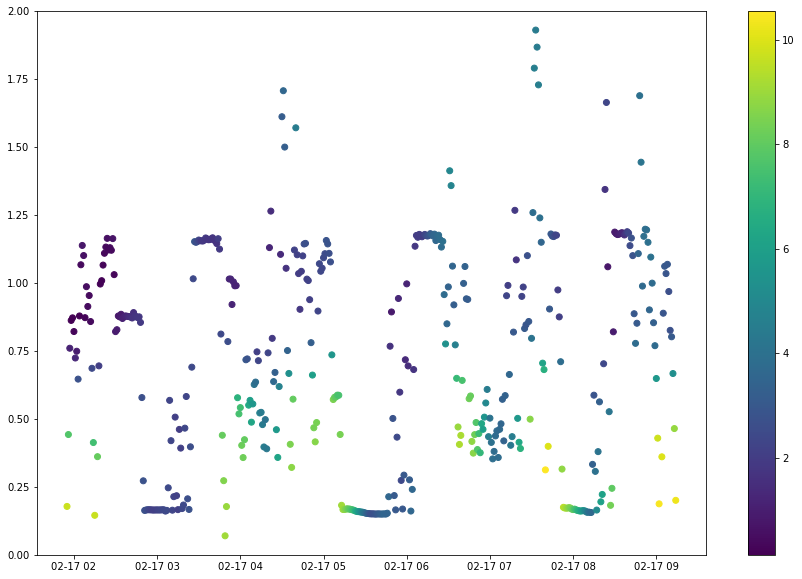

In [17]:
# plot the model values interpolated to aircraft altitude
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.scatter(tyme,rad_alt,c = pm1_su_int)
ax.set_ylim(0,2)
plt.colorbar(im,ax=ax)

Text(0, 0.5, 'MERRA-2 Sulfate')

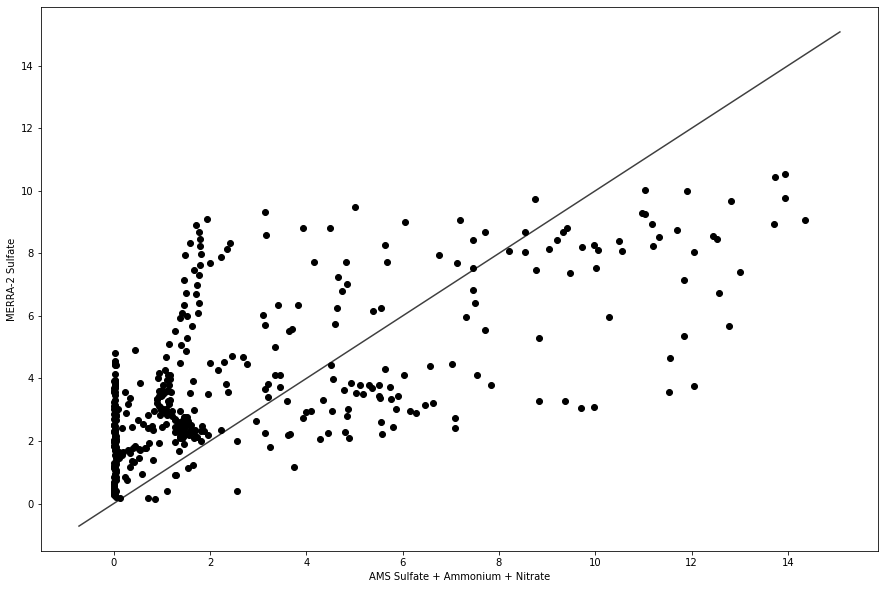

In [18]:
# compare MERRA-2 and AMS obs directly
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.plot(ams_pm1_su,pm1_su_int,'ko')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0) #1:1 line
ax.set_xlabel('AMS Sulfate + Ammonium + Nitrate')
ax.set_ylabel('MERRA-2 Sulfate')